# Evaluation and analysis

### Setting paths and environment variables:

In [1]:
import os

os.chdir('..')

In [2]:
os.getcwd()

'/home/ander/PycharmProjects/nnunet-ms-segmentation'

### Generic:

In [14]:
import os
from custom_scripts.A_config import (
    ROOT,
    TEST_IMAGES_DIR,
    TEST_LABELS_DIR,
    NNUNET_TEST_RESULTS_PATH,
    TERMINATION,
    DATASET,
    CONFIGURATION,
    PLAN,
    MSSEG2_IMAGES_DIR,
    MSSEG2_LABELS_DIR,
    MSSEG2_PREDICTIONS_DIR,
    TestDataset, MSSEG2_ANALYSIS_DIR
)

### Specific:

In [5]:
TRAINER = "nnUNetTrainerExtremeOversamplingLowLREarlyStopping"

In [17]:
TEST_DATASET = TestDataset.msseg2

In [18]:
ALL_TEST_PREDICTIONS_FOLDER = os.path.join(ROOT, 'nnUNet_test_results')
TEST_SPECIFIC_FOLDER_NAME = TRAINER + '__' + PLAN + "__" + CONFIGURATION
TEST_PREDICTIONS_FOLDER = os.path.join(ALL_TEST_PREDICTIONS_FOLDER, DATASET, TEST_SPECIFIC_FOLDER_NAME)

In [19]:
if TEST_DATASET == TestDataset.msseg2:
    TEST_PREDICTIONS_FOLDER = MSSEG2_PREDICTIONS_DIR
    TEST_LABELS_DIR = MSSEG2_LABELS_DIR
    TEST_IMAGES_DIR = MSSEG2_IMAGES_DIR

## Analysing specific cases:

In [20]:
import custom_scripts.F_evaluate_quantitative as equant

In [21]:
equant.TEST_PREDICTIONS_FOLDER = TEST_PREDICTIONS_FOLDER

In [22]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [23]:
test_images = os.listdir(TEST_IMAGES_DIR)
test_ids = sorted({file_name.split(".")[0][:-5] for file_name in test_images})

In [25]:
sample_case_num_idx = 7  # or sample from range(len(test_ids))
sample_case_id = test_ids[sample_case_num_idx]
sample_labels_path, sample_predictions_path = equant.get_paths(case_id=sample_case_id, test_dataset=TEST_DATASET,
                                                               labels=True, preds=True)

In [26]:
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO
from nnunetv2.evaluation.evaluate_predictions import compute_metrics

results = compute_metrics(
    reference_file=sample_labels_path,
    prediction_file=sample_predictions_path,
    image_reader_writer=SimpleITKIO(),
    labels_or_regions=[1, 2]
)

In [27]:
results

{'reference_file': '/home/ander/PycharmProjects/nnunet-ms-segmentation/NEW_LESIONS_CHALLENGE/LABELS/024.nii.gz',
 'prediction_file': '/home/ander/PycharmProjects/nnunet-ms-segmentation/NEW_LESIONS_CHALLENGE/PREDICTIONS/024.nii.gz',
 'metrics': {1: {'Dice': 0.0,
   'IoU': 0.0,
   'FP': 5324,
   'TP': 0,
   'FN': 0,
   'TN': 7215708,
   'n_pred': 5324,
   'n_ref': 0},
  2: {'Dice': 0.7077922077922078,
   'IoU': 0.5477386934673367,
   'FP': 57,
   'TP': 218,
   'FN': 123,
   'TN': 7220634,
   'n_pred': 275,
   'n_ref': 341}}}

In [29]:
sample_b_image, sample_fu_image = equant.read_images(case_id=sample_case_id, test_dataset=TEST_DATASET)
sample_labels, sample_predictions = equant.read_labels_and_preds(case_id=sample_case_id, test_dataset=TEST_DATASET)

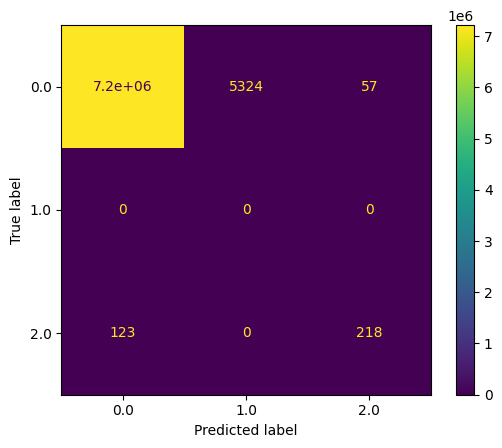

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=sample_labels.flatten(), y_pred=sample_predictions.flatten())

In [32]:
sample_b_image_path, sample_fu_image_path = equant.get_paths(case_id=sample_case_id, test_dataset=TEST_DATASET,
                                                             basal_im=True, follow_up_im=True)
raw_sample_b_image = nib.load(sample_b_image_path)

In [33]:
print(raw_sample_b_image)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (182, 218, 182)
affine:
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 182 218 182   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.5:9e026117'
aux_file        : b''
qform_code      : m

In [34]:
nib.aff2axcodes(raw_sample_b_image.affine)

('L', 'A', 'S')

[La orientación de los vóxeles es](https://github.com/eloydelas/lesion-segmentation-challenge-miccai21/blob/main/TFM_Implementacion.ipynb):

+ El primer eje va de derecha a izquierda (plano sagital);
+ El segundo eje va de detrás a adelante (plano coronal);
+ El tercer eje va de inferior a superior (plano axial).

In [35]:
IMAGES_SHAPE = sample_b_image.shape

### Visualizaciones de las imágenes y las máscaras:

#### Lesiones basales

In [48]:
basal_lesions = np.ma.masked_where(sample_labels != 1, sample_labels)

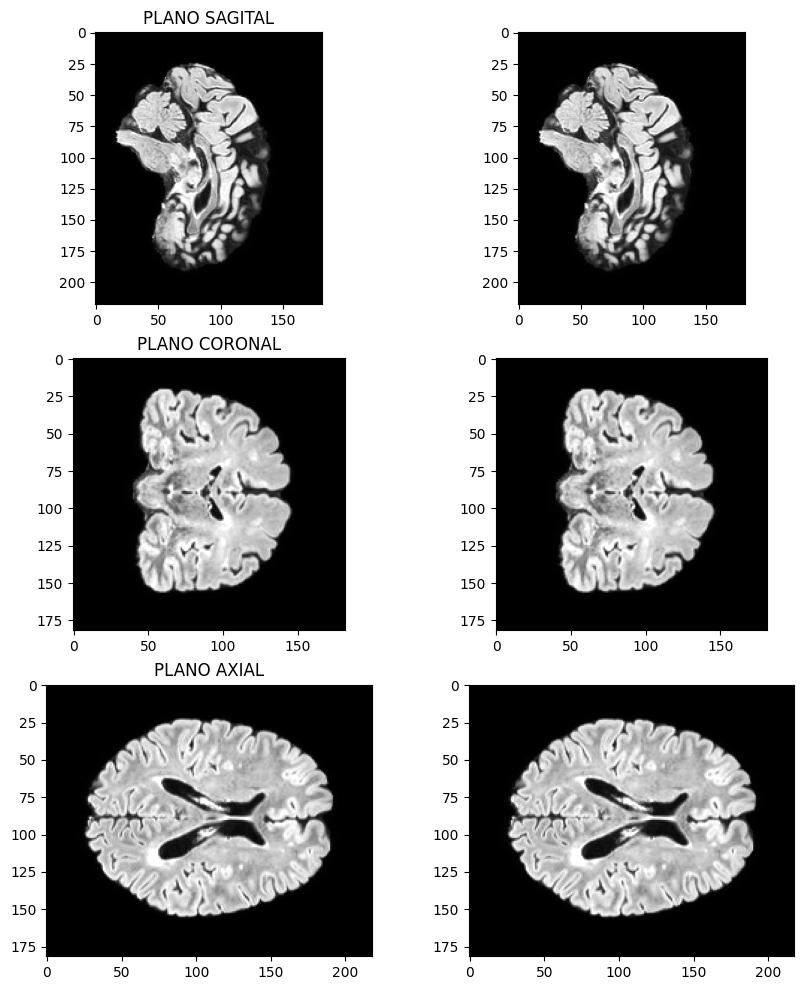

In [98]:
_, (row1, row2, row3) = plt.subplots(3, 2, figsize=(10, 12))
_ = row1[0].imshow(sample_b_image[IMAGES_SHAPE[0] // 2, :, :], cmap='gray')
_ = row1[1].imshow(sample_b_image[IMAGES_SHAPE[0] // 2, :, :], cmap='gray')
_ = row1[1].imshow(basal_lesions[IMAGES_SHAPE[0] // 2, :, :], cmap='autumn')
row1[0].set_title('PLANO SAGITAL')
_ = row2[0].imshow(sample_b_image[:, IMAGES_SHAPE[1] // 2, :], cmap='gray')
_ = row2[1].imshow(sample_b_image[:, IMAGES_SHAPE[1] // 2, :], cmap='gray')
_ = row2[1].imshow(basal_lesions[:, IMAGES_SHAPE[1] // 2, :], cmap='autumn')
row2[0].set_title('PLANO CORONAL')
_ = row3[0].imshow(sample_b_image[:, :, IMAGES_SHAPE[2] // 2], cmap='gray')
_ = row3[1].imshow(sample_b_image[:, :, IMAGES_SHAPE[2] // 2], cmap='gray')
_ = row3[1].imshow(basal_lesions[:, :, IMAGES_SHAPE[2] // 2], cmap='autumn')
row3[0].set_title('PLANO AXIAL');

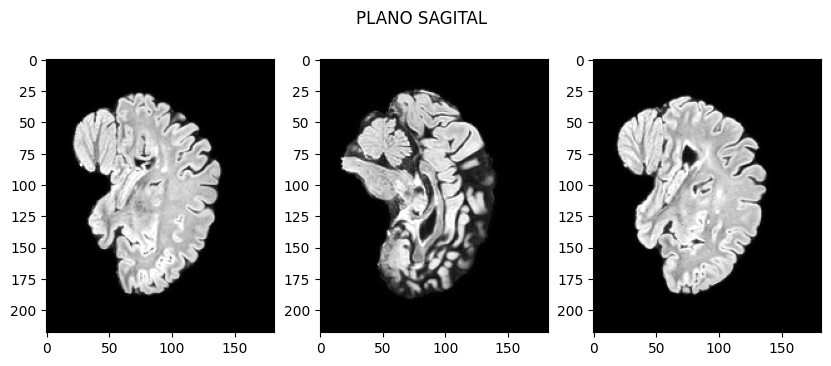

In [50]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(10, 12))
_ = axis1.imshow(sample_b_image[IMAGES_SHAPE[0] // 3, :, :], cmap='gray')
_ = axis1.imshow(basal_lesions[IMAGES_SHAPE[0] // 3, :, :], cmap='autumn')
_ = axis2.imshow(sample_b_image[IMAGES_SHAPE[0] // 2, :, :], cmap='gray')
_ = axis2.imshow(basal_lesions[IMAGES_SHAPE[0] // 2, :, :], cmap='autumn')
_ = axis3.imshow(sample_b_image[IMAGES_SHAPE[0] * 2 // 3, :, :], cmap='gray')
_ = axis3.imshow(basal_lesions[IMAGES_SHAPE[0] * 2 // 3, :, :], cmap='autumn')
fig.suptitle('PLANO SAGITAL', y=0.65);

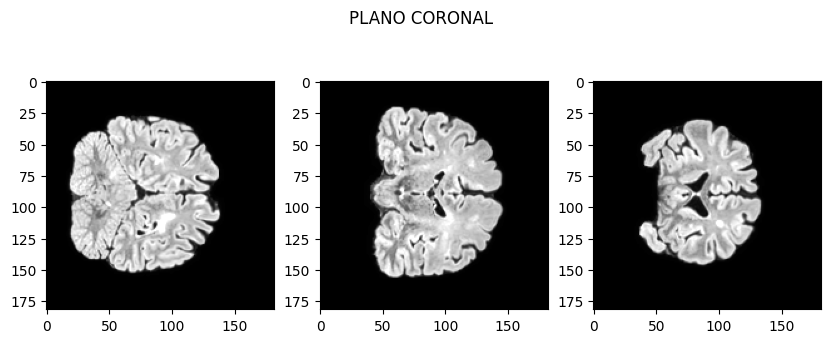

In [51]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(10, 12))
_ = axis1.imshow(sample_b_image[:, IMAGES_SHAPE[1] // 3, :], cmap='gray')
_ = axis1.imshow(basal_lesions[:, IMAGES_SHAPE[0] // 3, :], cmap='autumn')
_ = axis2.imshow(sample_b_image[:, IMAGES_SHAPE[1] // 2, :], cmap='gray')
_ = axis2.imshow(basal_lesions[:, IMAGES_SHAPE[0] // 2, :], cmap='autumn')
_ = axis3.imshow(sample_b_image[:, IMAGES_SHAPE[1] * 2 // 3, :], cmap='gray')
_ = axis3.imshow(basal_lesions[:, IMAGES_SHAPE[0] * 2 // 3, :], cmap='autumn')
fig.suptitle('PLANO CORONAL', y=0.65);

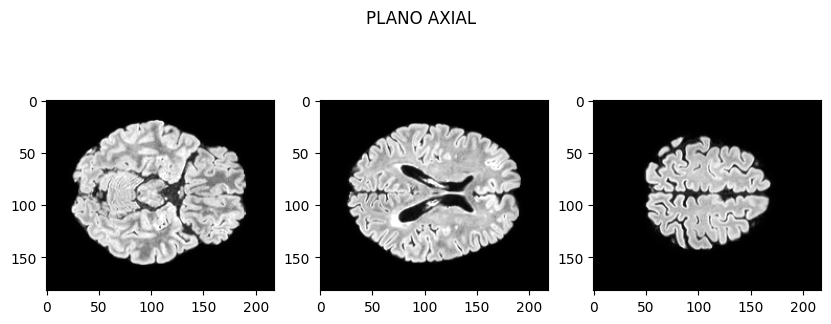

In [52]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(10, 12))
_ = axis1.imshow(sample_b_image[:, :, IMAGES_SHAPE[2] // 3], cmap='gray')
_ = axis1.imshow(basal_lesions[:, :, IMAGES_SHAPE[0] // 3], cmap='autumn')
_ = axis2.imshow(sample_b_image[:, :, IMAGES_SHAPE[2] // 2], cmap='gray')
_ = axis2.imshow(basal_lesions[:, :, IMAGES_SHAPE[0] // 2], cmap='autumn')
_ = axis3.imshow(sample_b_image[:, :, IMAGES_SHAPE[2] * 2 // 3], cmap='gray')
_ = axis3.imshow(basal_lesions[:, :, IMAGES_SHAPE[0] * 2 // 3], cmap='autumn')
fig.suptitle('PLANO AXIAL', y=0.65);

#### Lesiones nuevas

In [91]:
new_lesions = np.ma.masked_where(sample_labels != 2, sample_labels)

In [62]:
new_lesions_placements = np.where(sample_labels == 2)
new_lesions_placements = [
    (x, y, z) for x, y, z
    in zip(new_lesions_placements[0], new_lesions_placements[1], new_lesions_placements[2])
]

In [89]:
number_of_new_lesions = len(new_lesions_placements)
print(number_of_new_lesions)

341


In [87]:
sample_new_lesion_idx = np.random.choice(np.arange(len(new_lesions_placements)))
sample_new_lesion = new_lesions_placements[sample_new_lesion_idx]
sample_new_lesion

(108, 125, 113)

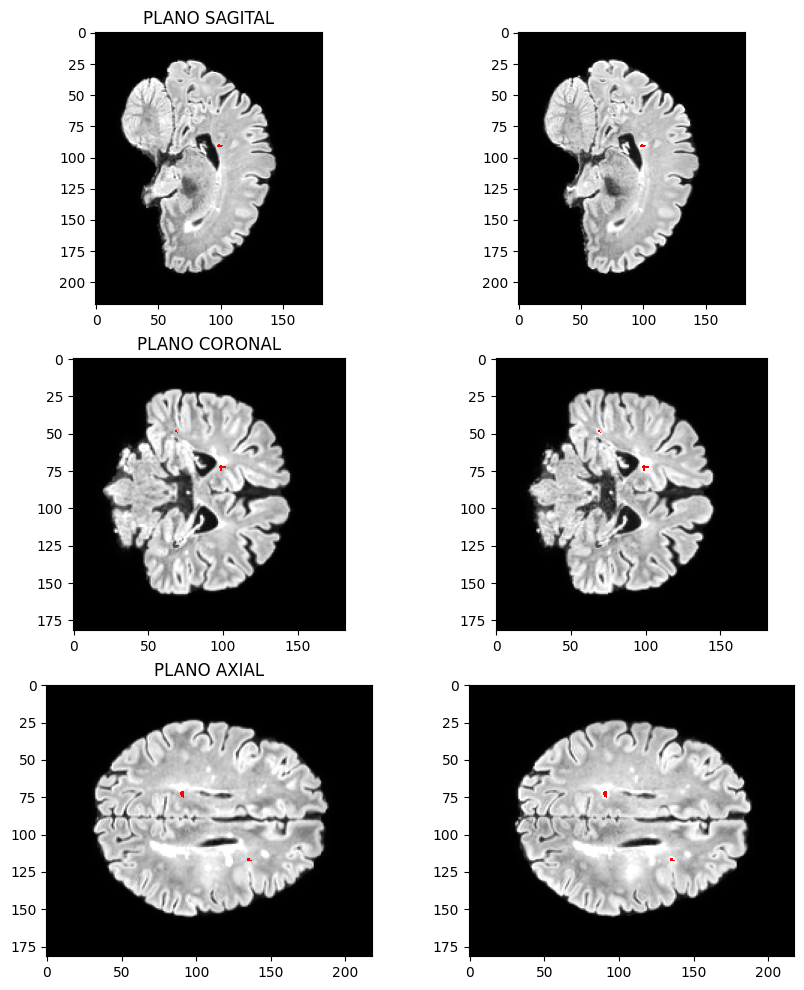

In [362]:
_, (row1, row2, row3) = plt.subplots(3, 2, figsize=(10, 12))
# Plano sagital:
# Basal
_ = row1[0].imshow(sample_b_image[sample_new_lesion[0], :, :], cmap='gray')
_ = row1[0].imshow(new_lesions[sample_new_lesion[0], :, :], cmap='autumn')
row1[0].set_title('PLANO SAGITAL')
# Follow up
_ = row1[1].imshow(sample_fu_image[sample_new_lesion[0], :, :], cmap='gray')
_ = row1[1].imshow(new_lesions[sample_new_lesion[0], :, :], cmap='autumn')
# Plano coronal:
# Basal
_ = row2[0].imshow(sample_b_image[:, sample_new_lesion[1], :], cmap='gray')
_ = row2[0].imshow(new_lesions[:, sample_new_lesion[1], :], cmap='autumn')
row2[0].set_title('PLANO CORONAL')
# Follow up
_ = row2[1].imshow(sample_fu_image[:, sample_new_lesion[1], :], cmap='gray')
_ = row2[1].imshow(new_lesions[:, sample_new_lesion[1], :], cmap='autumn')
# Plano axial:
# Basal
_ = row3[0].imshow(sample_b_image[:, :, sample_new_lesion[2]], cmap='gray')
_ = row3[0].imshow(new_lesions[:, :, sample_new_lesion[2]], cmap='autumn')
# Follow up
_ = row3[1].imshow(sample_fu_image[:, :, sample_new_lesion[2]], cmap='gray')
_ = row3[1].imshow(new_lesions[:, :, sample_new_lesion[2]], cmap='autumn')
row3[0].set_title('PLANO AXIAL');

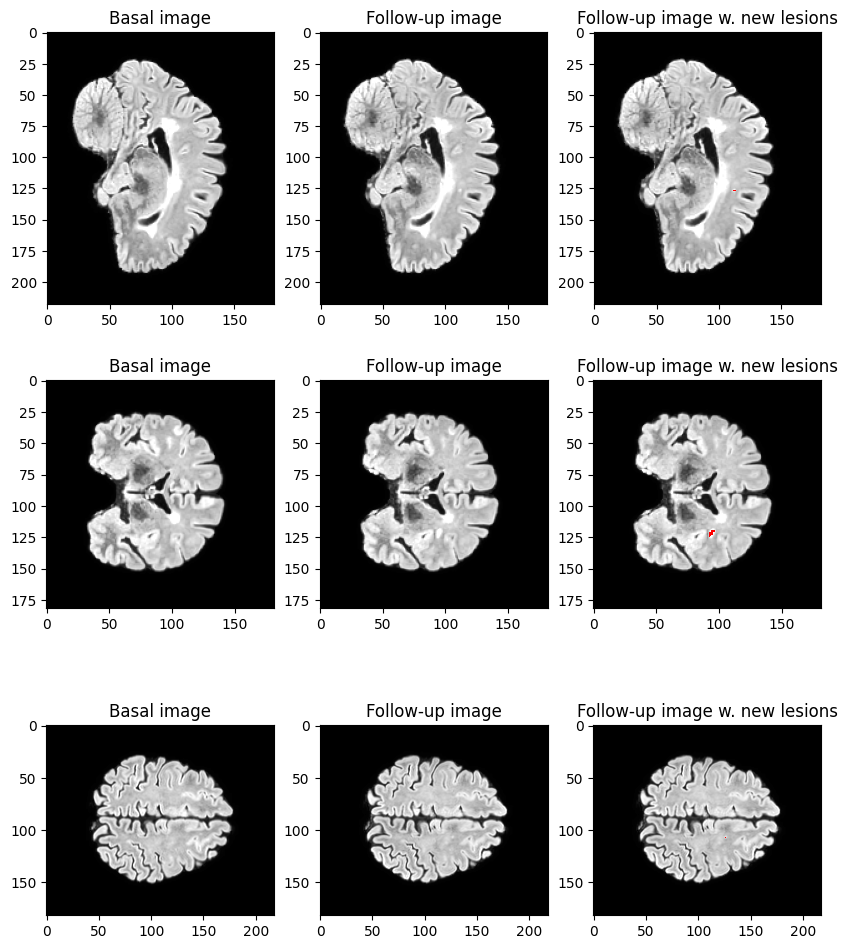

In [95]:
fig, (row1, row2, row3) = plt.subplots(3, 3, figsize=(10, 12))
# Plano sagital:
# Basal
_ = row1[0].imshow(sample_b_image[sample_new_lesion[0], :, :], cmap='gray')
row1[0].set_title('Basal image')
# Follow up
_ = row1[1].imshow(sample_fu_image[sample_new_lesion[0], :, :], cmap='gray')
row1[1].set_title('Follow-up image')
# Follow-up w. Mask
_ = row1[2].imshow(sample_fu_image[sample_new_lesion[0], :, :], cmap='gray')
_ = row1[2].imshow(new_lesions[sample_new_lesion[0], :, :], cmap='autumn')
row1[2].set_title('Follow-up image w. new lesions')
# Plano coronal:
# Basal
_ = row2[0].imshow(sample_b_image[:, sample_new_lesion[1], :], cmap='gray')
row2[0].set_title('Basal image')
# Follow up
_ = row2[1].imshow(sample_fu_image[:, sample_new_lesion[1], :], cmap='gray')
row2[1].set_title('Follow-up image')
# Follow-up w mask:
_ = row2[2].imshow(sample_fu_image[:, sample_new_lesion[1], :], cmap='gray')
_ = row2[2].imshow(new_lesions[:, sample_new_lesion[1], :], cmap='autumn')
row2[2].set_title('Follow-up image w. new lesions')
# Plano axial:
# Basal
_ = row3[0].imshow(sample_b_image[:, :, sample_new_lesion[2]], cmap='gray')
row3[0].set_title('Basal image')
# Follow up
_ = row3[1].imshow(sample_fu_image[:, :, sample_new_lesion[2]], cmap='gray')
row3[1].set_title('Follow-up image')
# Follow-up with mask
_ = row3[2].imshow(sample_fu_image[:, :, sample_new_lesion[2]], cmap='gray')
_ = row3[2].imshow(new_lesions[:, :, sample_new_lesion[2]], cmap='autumn')
row3[2].set_title('Follow-up image w. new lesions');

## Visualization of images, masks and predictions:

In [103]:
new_lesion_conf = np.zeros(sample_predictions.shape)
new_lesion_predictions = np.ma.masked_where(sample_predictions == 0, sample_predictions)
new_lesion_predictions[new_lesion_predictions != 2] = 0
new_lesion_labels = np.ma.masked_where(sample_labels == 0, sample_labels)
new_lesion_labels[new_lesion_labels != 2] = 0
new_lesion_conf[new_lesion_predictions == new_lesion_labels] = 1
new_lesion_conf[(new_lesion_predictions == 2) & (new_lesion_labels != 2)] = 2
new_lesion_conf[(new_lesion_predictions != 2) & (new_lesion_labels == 2)] = 3
new_lesion_conf = np.ma.masked_where(new_lesion_conf == 0, new_lesion_conf)

In [ ]:
np.unique(new_lesion_conf)  #%% md
# Evaluation and analysis

### Setting paths and environment variables:

In [ ]:
import os

os.chdir('..')

In [ ]:
os.getcwd()

### Generic:

In [ ]:
import os
from custom_scripts.A_config import (
    ROOT,
    TEST_IMAGES_DIR,
    TEST_LABELS_DIR,
    NNUNET_TEST_RESULTS_PATH,
    TERMINATION,
    DATASET,
    CONFIGURATION,
    PLAN,
    MSSEG2_IMAGES_DIR,
    MSSEG2_LABELS_DIR,
    MSSEG2_PREDICTIONS_DIR,
    TestDataset
)

### Specific:

In [ ]:
TRAINER = "nnUNetTrainerExtremeOversamplingLowLREarlyStopping"

In [ ]:
TEST_DATASET = TestDataset.msseg2

In [ ]:
ALL_TEST_PREDICTIONS_FOLDER = os.path.join(ROOT, 'nnUNet_test_results')
TEST_SPECIFIC_FOLDER_NAME = TRAINER + '__' + PLAN + "__" + CONFIGURATION
TEST_PREDICTIONS_FOLDER = os.path.join(ALL_TEST_PREDICTIONS_FOLDER, DATASET, TEST_SPECIFIC_FOLDER_NAME)

In [ ]:
if TEST_DATASET == TestDataset.msseg2:
    TEST_PREDICTIONS_FOLDER = MSSEG2_PREDICTIONS_DIR
    TEST_LABELS_DIR = MSSEG2_LABELS_DIR
    TEST_IMAGES_DIR = MSSEG2_IMAGES_DIR

## Analysing specific cases:

In [ ]:
import custom_scripts.F_evaluate_quantitative as equant

In [ ]:
equant.TEST_PREDICTIONS_FOLDER = TEST_PREDICTIONS_FOLDER

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
test_images = os.listdir(TEST_IMAGES_DIR)
test_ids = sorted({file_name.split(".")[0][:-5] for file_name in test_images})

In [ ]:
sample_case_num_idx = 7  # or sample from range(len(test_ids))
sample_case_id = test_ids[sample_case_num_idx]
sample_labels_path, sample_predictions_path = equant.get_paths(case_id=sample_case_id, test_dataset=TEST_DATASET,
                                                               labels=True, preds=True)

In [239]:
from nnunetv2.imageio.simpleitk_reader_writer import SimpleITKIO
from nnunetv2.evaluation.evaluate_predictions import compute_metrics

results = compute_metrics(
    reference_file=sample_labels_path,
    prediction_file=sample_predictions_path,
    image_reader_writer=SimpleITKIO(),
    labels_or_regions=[1, 2]
)

In [ ]:
sample_b_image, sample_fu_image = equant.read_images(case_id=sample_case_id, test_dataset=TEST_DATASET)
sample_labels, sample_predictions = equant.read_labels_and_preds(case_id=sample_case_id, test_dataset=TEST_DATASET)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=sample_labels.flatten(), y_pred=sample_predictions.flatten())

In [ ]:
sample_b_image_path, sample_fu_image_path = equant.get_paths(case_id=sample_case_id, test_dataset=TEST_DATASET,
                                                             basal_im=True, follow_up_im=True)
raw_sample_b_image = nib.load(sample_b_image_path)

In [ ]:
print(raw_sample_b_image)

In [ ]:
nib.aff2axcodes(raw_sample_b_image.affine)

[La orientación de los vóxeles es](https://github.com/eloydelas/lesion-segmentation-challenge-miccai21/blob/main/TFM_Implementacion.ipynb):

+ El primer eje va de derecha a izquierda (plano sagital);
+ El segundo eje va de detrás a adelante (plano coronal);
+ El tercer eje va de inferior a superior (plano axial).

In [238]:
IMAGES_SHAPE = sample_b_image.shape

### Visualizaciones de las imágenes y las máscaras:

In [274]:
def get_lesions_locations(labels, lesion_class: int):
    lesion_locations = np.where(labels == lesion_class)
    return [
        (x, y, z) for x, y, z
        in zip(lesion_locations[0], lesion_locations[1], lesion_locations[2])
    ]

In [275]:
def get_lesion_confusion_array(labels, predictions, lesion_class: int, masked: bool):
    confusion_array = np.zeros(labels.shape)
    lesion_predictions = np.copy(predictions)
    lesion_predictions[lesion_predictions != lesion_class] = -1  # Different from 0
    lesion_labels = np.copy(labels)
    lesion_labels[lesion_labels != lesion_class] = 0
    confusion_array[lesion_predictions == lesion_labels] = 1  # TP
    confusion_array[(lesion_predictions == lesion_class) & (lesion_labels != lesion_class)] = 2  # FP
    confusion_array[(lesion_predictions != lesion_class) & (lesion_labels == lesion_class)] = 3  # FN
    if masked:
        confusion_array = np.ma.masked_where(confusion_array == 0, confusion_array)
    return confusion_array

In [306]:
CMVal2Type = {
    1: "TP",
    2: "FP",
    3: "FN"
}

#### Lesiones basales

In [307]:
results['metrics'][1]

{'Dice': 0.0,
 'IoU': 0.0,
 'FP': 5324,
 'TP': 0,
 'FN': 0,
 'TN': 7215708,
 'n_pred': 5324,
 'n_ref': 0}

In [308]:
def plot_basal_lesion(b_im, fu_im, labels, central_voxel=None, patch_size: int = 25):
    # Masking others:
    only_basal_lesions = np.ma.masked_where(labels != 1, labels)
    # Limits:
    s_limits = [central_voxel[0] - patch_size, central_voxel[0] + patch_size]
    c_limits = [central_voxel[1] - patch_size, central_voxel[1] + patch_size]
    a_limits = [central_voxel[2] - patch_size, central_voxel[2] + patch_size]
    for i, limits in enumerate([s_limits, c_limits, a_limits]):
        limits[0] = max(limits[0], 0)
        limits[1] = min(limits[1], b_im.shape[i])
    # Plot:
    f, (r1, r2, r3) = plt.subplots(3, 3, figsize=(10, 12))
    # Plano sagital:
    s_zoom = np.s_[central_voxel[0], c_limits[0]:c_limits[1], a_limits[0]: a_limits[1]]
    # Basal
    _ = r1[0].imshow(b_im[s_zoom], cmap='gray')
    r1[0].set_title('Basal image')
    # Basal w. Mask
    _ = r1[2].imshow(b_im[s_zoom], cmap='gray')
    _ = r1[2].imshow(only_basal_lesions[s_zoom], cmap="autumn")
    r1[2].set_title('Basal image w. new lesions')
    # Follow up
    _ = r1[1].imshow(fu_im[s_zoom], cmap='gray')
    r1[1].set_title('Follow-up image')
    # Plano coronal:
    c_zoom = np.s_[s_limits[0]:s_limits[1], central_voxel[1], a_limits[0]: a_limits[1]]
    # Basal
    _ = r2[0].imshow(b_im[c_zoom], cmap='gray')
    r2[0].set_title('Basal image')
    # Basal w mask:
    _ = r2[2].imshow(b_im[c_zoom], cmap='gray')
    _ = r2[2].imshow(only_basal_lesions[c_zoom], cmap="autumn")
    r2[2].set_title('Basal image w. new lesions')
    # Follow up
    _ = r2[1].imshow(fu_im[c_zoom], cmap='gray')
    r2[1].set_title('Follow-up image')
    # Plano axial:
    a_zoom = np.s_[s_limits[0]:s_limits[1], c_limits[0]: c_limits[1], central_voxel[2]]
    # Basal
    _ = r3[0].imshow(b_im[a_zoom], cmap='gray')
    r3[0].set_title('Basal image')
    # Basal with mask
    _ = r3[2].imshow(b_im[a_zoom], cmap='gray')
    _ = r3[2].imshow(only_basal_lesions[a_zoom], cmap="autumn")
    r3[2].set_title('Basal image w. new lesions')
    # Follow up
    _ = r3[1].imshow(fu_im[a_zoom], cmap='gray')
    r3[1].set_title('Follow-up image')
    return f

In [309]:
true_basal_lesion_locations = get_lesions_locations(labels=sample_labels, lesion_class=1)
pred_basal_lesion_locations = get_lesions_locations(labels=sample_predictions, lesion_class=1)
basal_lesion_locations = true_basal_lesion_locations + pred_basal_lesion_locations

In [321]:
sample_basal_lesion_idx = np.random.choice(np.arange(len(basal_lesion_locations)))
sample_basal_lesion = basal_lesion_locations[sample_basal_lesion_idx]
sample_basal_lesion

(76, 157, 68)

In [322]:
# plot_basal_lesion(b_im=sample_b_image, fu_im=sample_fu_image, labels=new_lesions,
#                   central_voxel=sample_basal_lesion, patch_size=25)

In [323]:
basal_lesion_confusions = get_lesion_confusion_array(labels=sample_labels, predictions=sample_predictions,
                                                     lesion_class=1, masked=True)

In [324]:
sample_basal_lesion_type = CMVal2Type[basal_lesion_confusions[sample_basal_lesion]]
sample_basal_lesion_type

'FP'

In [359]:
def plot_basal_lesion_eval(b_im, fu_im, conf_mat, central_voxel, patch_size: int = 25):
    # TP is green, FP is red, FN is blue
    cmap = colors.ListedColormap(['green', 'red', 'blue'])
    # Limits:
    s_limits = [central_voxel[0] - patch_size, central_voxel[0] + patch_size]
    c_limits = [central_voxel[1] - patch_size, central_voxel[1] + patch_size]
    a_limits = [central_voxel[2] - patch_size, central_voxel[2] + patch_size]
    for i, limits in enumerate([s_limits, c_limits, a_limits]):
        limits[0] = max(limits[0], 0)
        limits[1] = min(limits[1], b_im.shape[i])

    # Plot:
    f, (r1, r2, r3) = plt.subplots(3, 3, figsize=(10, 12))
    # Plano sagital:
    s_zoom = np.s_[central_voxel[0], c_limits[0]:c_limits[1], a_limits[0]: a_limits[1]]
    # Basal
    _ = r1[0].imshow(b_im[s_zoom], cmap='gray')
    r1[0].set_title('Basal image')
    # Basal w. Mask
    _ = r1[2].imshow(b_im[s_zoom], cmap='gray')
    _ = r1[2].imshow(conf_mat[s_zoom], cmap=cmap, vmin=1, vmax=3)
    r1[2].set_title('Basal image w. new lesions')
    # Follow up
    _ = r1[1].imshow(fu_im[s_zoom], cmap='gray')
    r1[1].set_title('Follow-up image')
    # Plano coronal:
    c_zoom = np.s_[s_limits[0]:s_limits[1], central_voxel[1], a_limits[0]: a_limits[1]]
    # Basal
    _ = r2[0].imshow(b_im[c_zoom], cmap='gray')
    r2[0].set_title('Basal image')
    # Basal w mask:
    _ = r2[2].imshow(b_im[c_zoom], cmap='gray')
    _ = r2[2].imshow(conf_mat[c_zoom], cmap=cmap, vmin=1, vmax=3)
    r2[2].set_title('Basal image w. new lesions')
    # Follow up
    _ = r2[1].imshow(fu_im[c_zoom], cmap='gray')
    r2[1].set_title('Follow-up image')
    # Plano axial:
    a_zoom = np.s_[s_limits[0]:s_limits[1], c_limits[0]: c_limits[1], central_voxel[2]]
    # Basal
    _ = r3[0].imshow(b_im[a_zoom], cmap='gray')
    r3[0].set_title('Basal image')
    # Basal with mask
    _ = r3[2].imshow(b_im[a_zoom], cmap='gray')
    _ = r3[2].imshow(conf_mat[a_zoom], cmap=cmap, vmin=1, vmax=3)
    r3[2].set_title('Basal image w. new lesions')
    # Follow up
    _ = r3[1].imshow(fu_im[a_zoom], cmap='gray')
    r3[1].set_title('Follow-up image')
    return f

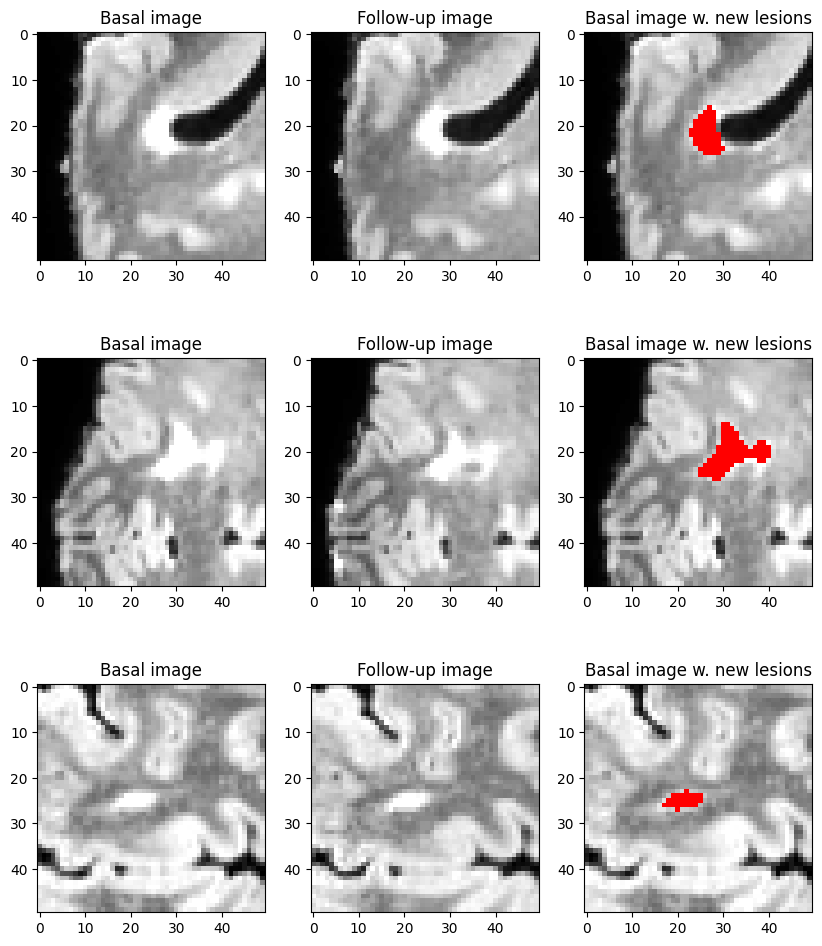

In [361]:
plot_basal_lesion_eval(b_im=sample_b_image, fu_im=sample_fu_image, conf_mat=basal_lesion_confusions,
                       central_voxel=sample_basal_lesion, patch_size=25);

#### Lesiones nuevas

In [328]:
results['metrics'][2]

{'Dice': 0.7077922077922078,
 'IoU': 0.5477386934673367,
 'FP': 57,
 'TP': 218,
 'FN': 123,
 'TN': 7220634,
 'n_pred': 275,
 'n_ref': 341}

In [329]:
true_new_lesion_locations = get_lesions_locations(labels=sample_labels, lesion_class=2)
pred_new_lesion_locations = get_lesions_locations(labels=sample_predictions, lesion_class=2)
new_lesion_locations = true_new_lesion_locations + pred_new_lesion_locations

In [330]:
sample_new_lesion_idx = np.random.choice(np.arange(len(new_lesions_placements)))
sample_new_lesion = new_lesions_placements[sample_new_lesion_idx]
sample_new_lesion

(72, 90, 99)

In [332]:
def plot_new_lesion(b_im, fu_im, labels, central_voxel, patch_size: int = 25):
    only_new_lesions = np.ma.masked_where(labels != 2, labels)
    # Limits:
    s_limits = [central_voxel[0] - patch_size, central_voxel[0] + patch_size]
    c_limits = [central_voxel[1] - patch_size, central_voxel[1] + patch_size]
    a_limits = [central_voxel[2] - patch_size, central_voxel[2] + patch_size]
    for i, limits in enumerate([s_limits, c_limits, a_limits]):
        limits[0] = max(limits[0], 0)
        limits[1] = min(limits[1], b_im.shape[i])
    # Plot:
    f, (r1, r2, r3) = plt.subplots(3, 3, figsize=(10, 12))
    # Plano sagital:
    s_zoom = np.s_[central_voxel[0], c_limits[0]:c_limits[1], a_limits[0]: a_limits[1]]
    # Basal
    _ = r1[0].imshow(b_im[s_zoom], cmap='gray')
    r1[0].set_title('Basal image')
    # Follow up
    _ = r1[1].imshow(fu_im[s_zoom], cmap='gray')
    r1[1].set_title('Follow-up image')
    # Follow-up w. Mask
    _ = r1[2].imshow(fu_im[s_zoom], cmap='gray')
    _ = r1[2].imshow(only_new_lesions[s_zoom], cmap="autumn")
    r1[2].set_title('Follow-up image w. new lesions')
    # Plano coronal:
    c_zoom = np.s_[s_limits[0]:s_limits[1], central_voxel[1], a_limits[0]: a_limits[1]]
    # Basal
    _ = r2[0].imshow(b_im[c_zoom], cmap='gray')
    r2[0].set_title('Basal image')
    # Follow up
    _ = r2[1].imshow(fu_im[c_zoom], cmap='gray')
    r2[1].set_title('Follow-up image')
    # Follow-up w mask:
    _ = r2[2].imshow(fu_im[c_zoom], cmap='gray')
    _ = r2[2].imshow(only_new_lesions[c_zoom], cmap="autumn")
    r2[2].set_title('Follow-up image w. new lesions')
    # Plano axial:
    a_zoom = np.s_[s_limits[0]:s_limits[1], c_limits[0]: c_limits[1], central_voxel[2]]
    # Basal
    _ = r3[0].imshow(b_im[a_zoom], cmap='gray')
    r3[0].set_title('Basal image')
    # Follow up
    _ = r3[1].imshow(fu_im[a_zoom], cmap='gray')
    r3[1].set_title('Follow-up image')
    # Follow-up with mask
    _ = r3[2].imshow(fu_im[a_zoom], cmap='gray')
    _ = r3[2].imshow(only_new_lesions[a_zoom], cmap="autumn")
    r3[2].set_title('Follow-up image w. new lesions')
    return f

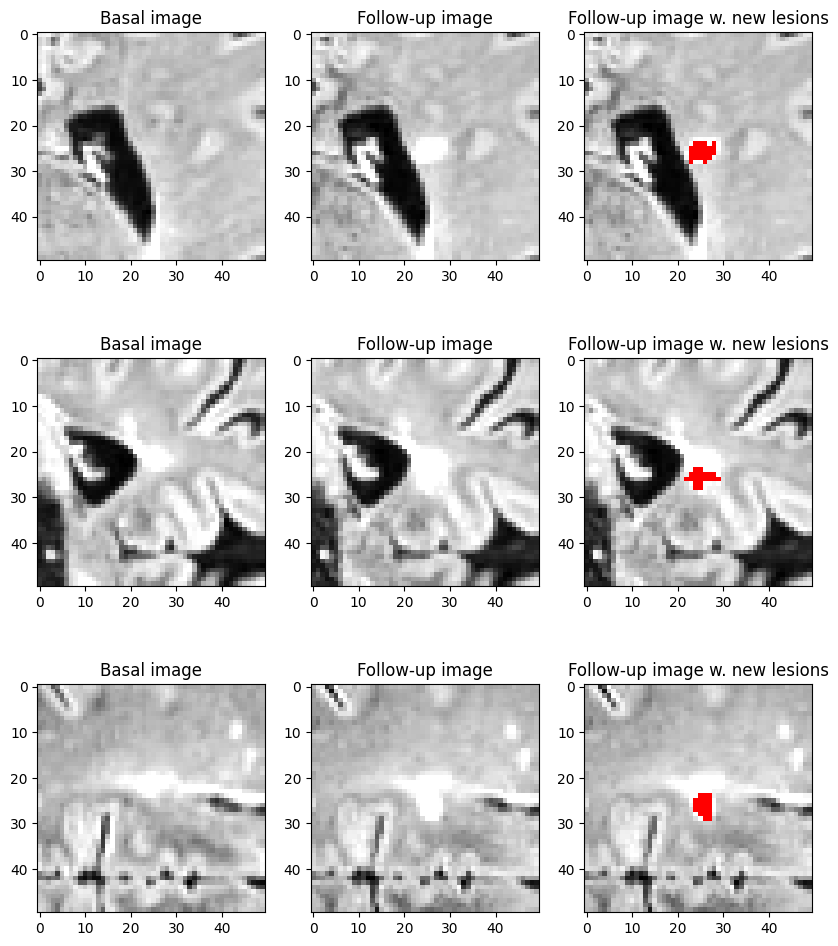

In [333]:
plot_new_lesion(b_im=sample_b_image, fu_im=sample_fu_image, labels=new_lesions,
                central_voxel=sample_new_lesion, patch_size=25)

In [334]:
new_lesion_confusion_array = get_lesion_confusion_array(labels=sample_labels, predictions=sample_predictions,
                                                        lesion_class=2, masked=True)

In [335]:
sample_new_lesion_type = CMVal2Type[new_lesion_confusion_array[sample_new_lesion]]
sample_new_lesion_type

'TP'

In [364]:
def plot_new_lesion_eval(b_im, fu_im, conf_mat, central_voxel, patch_size: int = 25):
    # TP is green, FP is red, FN is blue
    cmap = colors.ListedColormap(['green', 'red', 'blue'])
    # Limits:
    s_limits = [central_voxel[0] - patch_size, central_voxel[0] + patch_size]
    c_limits = [central_voxel[1] - patch_size, central_voxel[1] + patch_size]
    a_limits = [central_voxel[2] - patch_size, central_voxel[2] + patch_size]
    for i, limits in enumerate([s_limits, c_limits, a_limits]):
        limits[0] = max(limits[0], 0)
        limits[1] = min(limits[1], b_im.shape[i])

    # Plot:
    f, (r1, r2, r3) = plt.subplots(3, 3, figsize=(10, 12))
    # Plano sagital:
    s_zoom = np.s_[central_voxel[0], c_limits[0]:c_limits[1], a_limits[0]: a_limits[1]]
    # Basal
    _ = r1[0].imshow(b_im[s_zoom], cmap='gray')
    r1[0].set_title('Basal image')
    # Follow up
    _ = r1[1].imshow(fu_im[s_zoom], cmap='gray')
    r1[1].set_title('Follow-up image')
    # Follow-up w. Mask
    _ = r1[2].imshow(fu_im[s_zoom], cmap='gray')
    _ = r1[2].imshow(conf_mat[s_zoom], cmap=cmap, vmin=1, vmax=3)
    r1[2].set_title('Follow-up image w. new lesions')
    # Plano coronal:
    c_zoom = np.s_[s_limits[0]:s_limits[1], central_voxel[1], a_limits[0]: a_limits[1]]
    # Basal
    _ = r2[0].imshow(b_im[c_zoom], cmap='gray')
    r2[0].set_title('Basal image')
    # Follow up
    _ = r2[1].imshow(fu_im[c_zoom], cmap='gray')
    r2[1].set_title('Follow-up image')
    # Follow-up w mask:
    _ = r2[2].imshow(fu_im[c_zoom], cmap='gray')
    _ = r2[2].imshow(conf_mat[c_zoom], cmap=cmap, vmin=1, vmax=3)
    r2[2].set_title('Follow-up image w. new lesions')
    # Plano axial:
    a_zoom = np.s_[s_limits[0]:s_limits[1], c_limits[0]: c_limits[1], central_voxel[2]]
    # Basal
    _ = r3[0].imshow(b_im[a_zoom], cmap='gray')
    r3[0].set_title('Basal image')
    # Follow up
    _ = r3[1].imshow(fu_im[a_zoom], cmap='gray')
    r3[1].set_title('Follow-up image')
    # Follow-up with mask
    _ = r3[2].imshow(fu_im[a_zoom], cmap='gray')
    _ = r3[2].imshow(conf_mat[a_zoom], cmap=cmap, vmin=1, vmax=3)
    r3[2].set_title('Follow-up image w. new lesions')
    return f

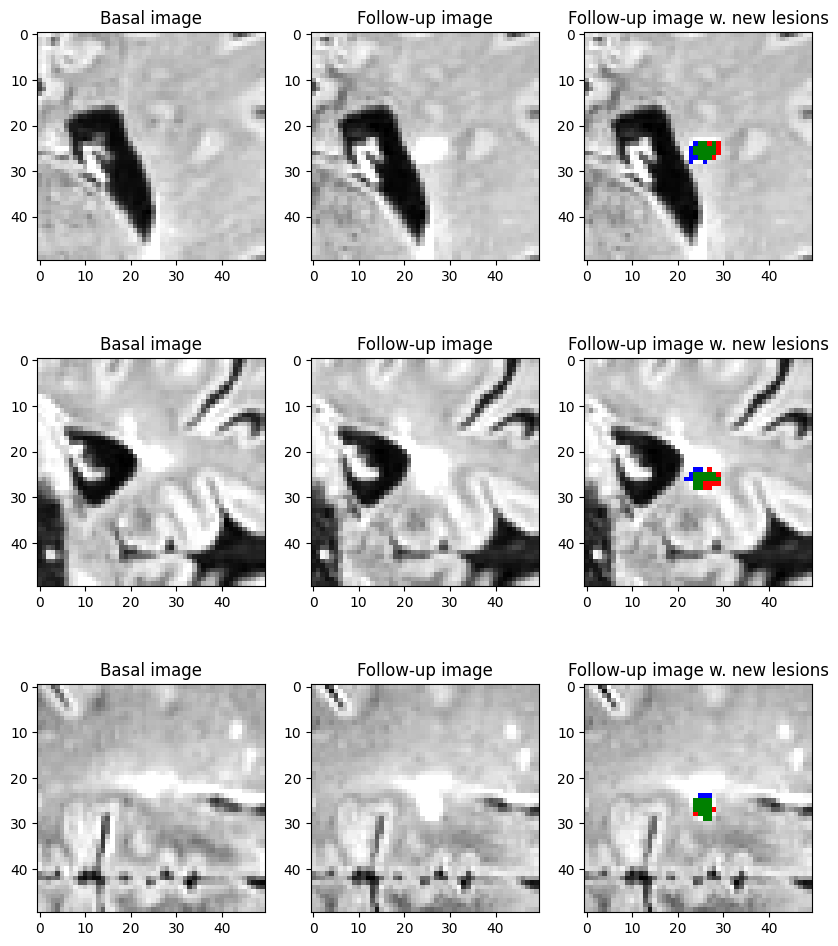

In [363]:
fig = plot_new_lesion_eval(b_im=sample_b_image, fu_im=sample_fu_image, conf_mat=new_lesion_conf,
                           central_voxel=sample_new_lesion, patch_size=25)

In [358]:
fig.savefig(MSSEG2_ANALYSIS_DIR / f"{TestDataset.msseg2}_{sample_case_id}_{sample_new_lesion}.png");